In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime

In [69]:
# 1. Daten einlesen
data = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/01_merged_data.csv", parse_dates=['Datum'], na_filter=False)  

In [73]:
# 2. Datenvorbereitung
relevant_columns = ['Warengruppe', 
                    'Bewoelkung', 
                    'Temperatur', 
                    'Windgeschwindigkeit', 
                    'wochentag', 
                    'is_niederschlag', 
                    'niederschlag_intesitaet', 
                    'is_gewitter', 
                    'temperatur_cat', 
                    'is_kielerWoche',
                    'is_holiday', 
                    'is_heimspiel_thw', 
                    'is_heimspiel_holstein', 
                    'is_school_holidays',
                    'holiday_name',
                    'school_holiday_name']          

# Entferne Zeilen mit fehlenden Werten
data = data.dropna(subset=[col for col in data.columns if col != 'Umsatz'])

data['Umsatz'] = pd.to_numeric(data['Umsatz'], errors='coerce')

data['is_gewitter'] = data['is_gewitter'].astype(bool)
data['is_kielerWoche'] = data['is_kielerWoche'].astype(bool)
data['is_holiday'] = data['is_holiday'].astype(bool)
data['is_heimspiel_thw'] = data['is_heimspiel_thw'].astype(bool)
data['is_heimspiel_holstein'] = data['is_heimspiel_holstein'].astype(bool)
data['is_school_holidays'] = data['is_school_holidays'].astype(bool)

data['Bewoelkung'] = pd.to_numeric(data['Bewoelkung'], errors='coerce')
data['Bewoelkung'] = data['Bewoelkung'].astype(int)
data['wochentag'] = data['wochentag'].astype(int)
data['is_niederschlag'] = data['is_niederschlag'].astype(int)
data['niederschlag_intesitaet'] = data['niederschlag_intesitaet'].astype(int)
data['wochentag'] = data['wochentag'].astype(int)
data['temperatur_cat'] = data['temperatur_cat'].astype(int)
 
data['holiday_name'] = data['holiday_name'].astype(str)
data['school_holiday_name'] = data['school_holiday_name'].astype(str)

print(data.info())

# 3. Trennen der Daten in Train, Validation und Test
train_data = data[(data['Datum'] >= '2013-07-01') & (data['Datum'] <= '2017-07-31')]
val_data = data[(data['Datum'] >= '2017-08-01') & (data['Datum'] <= '2018-07-31')]
test_data = data[(data['Datum'] >= '2018-08-01') & (data['Datum'] <= '2019-07-31')]

# Features und Ziel definieren
features = [col for col in relevant_columns if col not in ['id', 'Datum', 'Umsatz','holiday_name', 'school_holiday_name']]
target = "Umsatz"

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]
X_test = test_data[features]

# 4. Skalierung der Features
# Identify numerical and categorical features
numerical_features = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'wochentag']
categorical_features = ['Warengruppe', 'is_niederschlag', 'niederschlag_intesitaet', 'temperatur_cat']  # Add more if needed # , 'holiday_name','school_holiday_name'
boolean_features = ['is_gewitter', 'is_kielerWoche', 'is_gewitter', 'is_holiday', 'is_heimspiel_thw', 'is_heimspiel_holstein', 'is_school_holidays']

# Create a ColumnTransformer to apply different scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_features)   # One-hot encode categorical features
    ],
    remainder='passthrough'  # Keep other columns unchanged (like 'id' and 'Datum')
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

# 5. Neuronales Netz definieren
model = Sequential([
    # Eingabeschicht mit stärkerer Regularisierung
    Dense(64, activation='relu', 
          input_dim=X_train_scaled.shape[1],
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Mittlere Schicht
    Dense(32, activation='relu',
          kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    
    # Letzte versteckte Schicht
    Dense(16, activation='relu',
          kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    
    # Ausgabeschicht
    Dense(1, activation='linear')
])

# Optimierer und Callbacks
optimizer = Adam(learning_rate=0.001)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min'
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# 6. Modell kompilieren
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# 7. Modell trainieren

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=1000,  # Anzahl der Trainingsdurchläufe
    batch_size=32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


<class 'pandas.core.frame.DataFrame'>
Index: 11029 entries, 0 to 11163
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11029 non-null  int64         
 1   Datum                    11029 non-null  datetime64[ns]
 2   Warengruppe              11029 non-null  int64         
 3   Umsatz                   9264 non-null   float64       
 4   Bewoelkung               11029 non-null  int64         
 5   Temperatur               11029 non-null  object        
 6   Windgeschwindigkeit      11029 non-null  object        
 7   wochentag                11029 non-null  int64         
 8   is_niederschlag          11029 non-null  int64         
 9   niederschlag_intesitaet  11029 non-null  int64         
 10  is_gewitter              11029 non-null  bool          
 11  temperatur_cat           11029 non-null  int64         
 12  is_kielerWoche           11029 non-nu

/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 64454.2617 - mae: 207.0904 - mse: 64453.3242 - val_loss: 53457.4766 - val_mae: 195.9901 - val_mse: 53456.5547
Epoch 2/1000
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62179.5586 - mae: 206.2008 - mse: 62178.6289 - val_loss: 47492.8398 - val_mae: 187.9175 - val_mse: 47491.8906
Epoch 3/1000
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 54818.3398 - mae: 197.5913 - mse: 54817.3945 - val_loss: 42854.7344 - val_mae: 181.4750 - val_mse: 42853.7773
Epoch 4/1000
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47405.1797 - mae: 186.8796 - mse: 47404.2227 - val_loss: 36335.2500 - val_mae: 169.5255 - val_mse: 36334.2852
Epoch 5/1000
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 41034.8516 - mae: 173.5309 - mse: 41033.8828 - val_loss: 27565.6367 - val_mae: 149.4885 - val_mse: 27564.6465
Epoch 6/1000
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 32192.8359 - mae: 154.7207 - mse: 32191.8438 - val_loss: 22030.4258 - val_mae: 134.7148 - v

In [ ]:

# 8. Modell bewerten

# Evaluate the model on the validation set
loss, mae, mse = model.evaluate(X_val_scaled, y_val, verbose=0)

# Print MAE and MSE
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Get predictions
y_pred = model.predict(X_val_scaled).flatten()

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    # Avoid division by zero by using np.where to handle zeros in y_true
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100

mape = calculate_mape(y_val, y_pred)

validation_df = pd.DataFrame({
    'id': val_data['id'],
    'Warengruppe': val_data['Warengruppe'],
    'Umsatz': val_data['Umsatz'],
    'pred': y_pred
})


# Function to calculate MAPE for each group
def calculate_mape(group):
    return np.mean(np.abs((group['Umsatz'] - group['pred']) / group['Umsatz'])) * 100

# Group by product group and calculate MAPE
grouped_mape = validation_df.groupby('Warengruppe').apply(calculate_mape).reset_index(name='mape')

print(f"Mean Absolute Percentage Error: {mape:.2f}%")
for index, row in grouped_mape.iterrows():
    print(f"Warengruppe: {row['Warengruppe']:.0f}, MAPE: {row['mape']:.2f}%")

Mean Absolute Error: 35.4833
Mean Squared Error: 3156.4736
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
Mean Absolute Percentage Error: 20.32%
Warengruppe: 1, MAPE: 22.70%
Warengruppe: 2, MAPE: 16.07%
Warengruppe: 3, MAPE: 18.79%
Warengruppe: 4, MAPE: 21.63%
Warengruppe: 5, MAPE: 18.02%
Warengruppe: 6, MAPE: 52.63%


/tmp/ipykernel_6975/3239355526.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mape = validation_df.groupby('Warengruppe').apply(calculate_mape).reset_index(name='mape')


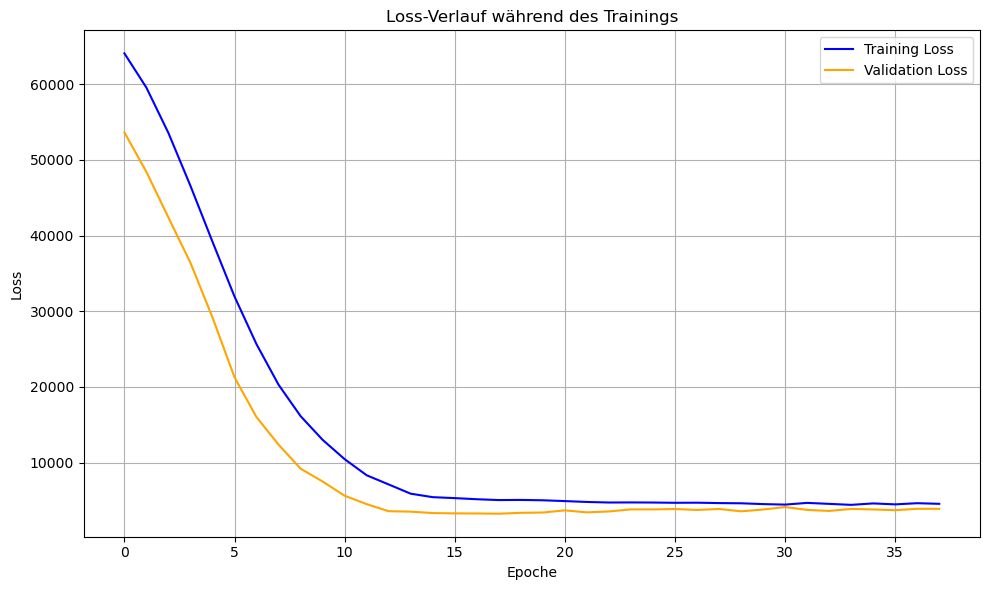

In [72]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

# Adjust epochs based on the length of training losses
num_epochs = len(training_losses)
epochs = np.arange(num_epochs)

# Figure und Axes erstellen
plt.figure(figsize=(10, 6))

# Plots erstellen
plt.plot(epochs, training_losses, label='Training Loss', color='blue')
plt.plot(epochs, validation_losses, label='Validation Loss', color='orange')

# Titel und Beschriftungen hinzufügen
plt.title('Loss-Verlauf während des Trainings')
plt.xlabel('Epoche')
plt.ylabel('Loss')

# Gitter hinzufügen
plt.grid(True)

# Legende hinzufügen
plt.legend()

# Layout optimieren
plt.tight_layout()

# Plot anzeigen
plt.show()

# Optional: Plot speichern
# plt.savefig('loss_plot.png')


In [74]:
# 9. Vorhersagen generieren
predictions = model.predict(X_test_scaled).flatten()

# 10. Ergebnisse anzeigen
predictions_df = pd.DataFrame({
    'id': test_data['id'],
    'Umsatz': predictions
})

submission = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/raw-data/test.csv", usecols=["id"])
submission = pd.merge(submission, predictions_df, on="id", how='left').fillna(0)

print(submission.info())
print(submission.head())

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1830 non-null   int64  
 1   Umsatz  1830 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 21.6 KB
None
        id      Umsatz
0  1808011  122.022865
1  1808021  118.654190
2  1808031  117.478638
3  1808041  117.263710
4  1808051  119.601372


In [77]:
# Optional: Ergebnisse speichern
now = datetime.now()

submission.to_csv(f"./{now:%Y%m%d%H%M}-submission.csv", index=False)